In [ ]:
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 709 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [ ]:
import numpy as np 
import pandas as pd
import time
import os
import shutil
import itertools 
import matplotlib.pyplot as plt





from torch_geometric.data import Data, Dataset#,DataLoader
from torch_geometric.loader import DataLoader
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torch_geometric.transforms as Tr
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid
from torch.optim.lr_scheduler import StepLR

from collections import namedtuple



In [ ]:
#plot parameters
FIGSIZE = (14,7)
FIG_TITLE = 22
FIG_AXIS = 14
FIG_LEGEND = 12

In [ ]:
class GraphDataset(Dataset):
    def __init__(self,graph_files,file_name,transform=None, pre_transform=None):
        super(GraphDataset,self).__init__()

        self.graph_files = graph_files
        self.file_name = file_name
    
    @property                 
    def raw_file_names(self):
        return self.graph_files

    @property
    def processed_file_names(self):
        return []

   
        
    def get(self, idx):
          
          data = torch.load(f'/PATH_TO_TEST/{self.file_name}' + f'data_{idx}.pt')
          
          
          return data    
          
    def len(self):
          
          return len(self.graph_files)

In [ ]:
home_dir = "../"   
test ='GRAPH_FINAL_TEST_MASTER/'
indir = '/PATH_TO_TEST/'
    
graph_files_test = np.array(os.listdir(indir + test))
graph_files_test = [os.path.join(indir+test,file)
                           for file in graph_files_test]
test_set = GraphDataset(graph_files_test, test)


In [ ]:
event = 25
plot_df = pd.DataFrame({'r':test_set.get(event).x[:,0], 'phi':test_set.get(event).x[:,1], 'z':test_set.get(event).x[:,2],
                      'ita':test_set.get(event).x[:,3], 'x':test_set.get(event).x[:,4],'y':test_set.get(event).x[:,5]})

In [ ]:
true_8_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_06.txt', delimiter = ",")
true_7_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_05.txt', delimiter = ",")
true_6_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_04.txt', delimiter = ",")
true_5_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_03.txt', delimiter = ",")
true_4_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_02.txt', delimiter = ",")
true_3_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_01.txt', delimiter = ",")
true_2_0=np.loadtxt('/PATH_TO_FULL_TRACK_INDEX/true_track_final_00.txt', delimiter = ",")


In [ ]:
IMG_SIZE = 37

#loop through layers
def hough_matrix(df,bins,img_size):
  track_pic = np.zeros((img_size-1,img_size-1))   # at the end remove lat column and last row
  for i in range(len(df)):
    #temporary matrix 
    temp_pic = np.zeros((img_size,img_size)) 
    # calculate qA/pt
    qa_pt = (phi0 - df.phi.values[i])/	df.r.values[i]
    #update temporary matrix where qa/pt is in bin 
    for i in range(len(temp_pic)-1):
      temp_pic[:,i][np.where((qa_pt<= bins[i]) & (qa_pt>= bins[i+1]))] = 1 

    temp_pic = np.delete(temp_pic, len(temp_pic)-1, 1)  #delete last column
    temp_pic = temp_pic[:-1]  #delete last row

    #adding the matrices create the final image   
    track_pic+=temp_pic
  return track_pic

In [ ]:
def get_bins(df,img_size):
  len_df = len(df)
  min_arr = np.zeros(len_df)
  max_arr = np.zeros(len_df)
  for i in range(len_df):
      
    qa_pt = (phi0 - df.phi.values[i])/	df.r.values[i]
    min_arr[i] = min(qa_pt)
    max_arr[i] = max(qa_pt)
  return np.linspace(max(max_arr),min(min_arr),img_size)

In [ ]:

noise_size = 25
def adding_noise(img_size,noise_size):
  noise_array = np.random.randint(1,img_size,noise_size)
  noise = np.zeros((img_size-1,img_size-1))
  for elem in noise_array:
    flip = np.random.randint(0,2)
    if flip:
      diagonal = np.fliplr(np.eye(img_size-1, k=elem)).T
    else:
      diagonal = np.eye(img_size-1, k=elem)

    noise+=diagonal
  return noise

In [ ]:
times=[]

In [ ]:
# 873699289782551528   
#create dataframe for one particle

phi0 = np.linspace(2,-3,IMG_SIZE-1)
tracks_name = 'true_noise'
file_num=5
true_file = true_8_0
# noise_file = true3
def hough_transform(phi0,tracks_name,file_num,img_size,add_noise = True):

  track_list =[]
  plot_idx =0

  dir = f'/PATH_TO_CNN_IMAGES/CNN_txt_files_{file_num}/{tracks_name}'
  if os.path.exists(dir):
    shutil.rmtree(dir)
  os.makedirs(dir)

  
  for pid in true_file:
    test_t0 = time.time()
    df8 = plot_df.iloc[pid]
    bins8 = get_bins(df8,img_size)
    track_pic8 = hough_matrix(df8,bins8,img_size)
   
    track_pic =   track_pic8.copy() 
    t = time.time()-test_t0
    times.append(t)
 
    if add_noise:
      adding nosie
     
    
      df5 = plot_df.iloc[noise_file[rand_idx5]]
      bins5 = get_bins(df5,img_size)
      track_pic5 = hough_matrix(df5,bins5,img_size)
      track_pic = track_pic5+track_pic.copy()

      noise = adding_noise(img_size,noise_size)
      track_pic = track_pic.copy()+noise

  
   
    np.savetxt(dir+f'/test_{plot_idx}.txt', track_pic, delimiter=',')
    # plot every 10 
    if plot_idx%10 == 0:
      print(f'PLOT NUMBER {plot_idx}')
      plt.subplot()
      plt.imshow(track_pic)

      plt.colorbar()

      plt.show()
    plot_idx+=1

  print(f'tracks  = {plot_idx}')

hough_transform(phi0,tracks_name,file_num, IMG_SIZE)


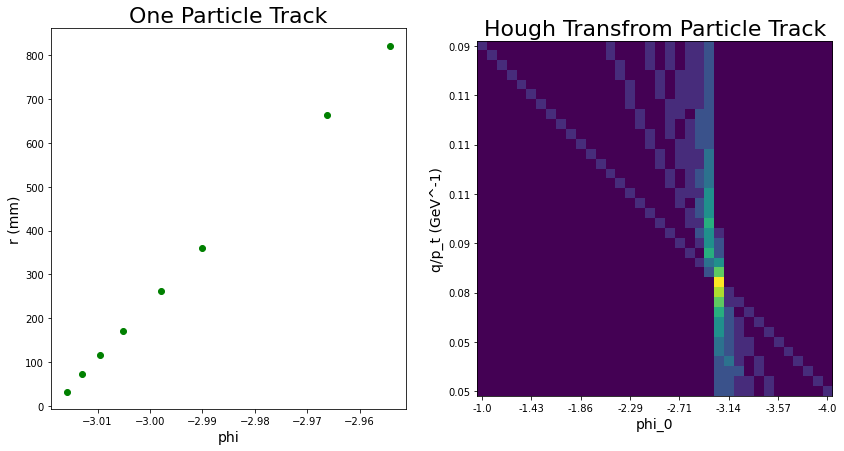

In [ ]:
df = plot_df.iloc[true_8[0]]
phi0_plot = np.round(np.linspace(0,35,8),2)
phi0_plot2 = np.round(np.linspace(-1,-4,8),2)
qa_pt_plot = np.round((phi0_plot - df.phi.values)/	df.r.values,2)
fig,ax = plt.subplots(1,2,figsize=FIGSIZE)

ax[0].scatter(df.phi,df.r,color='green')
ax[0].set_title('One Particle Track',fontsize=FIG_TITLE)
ax[0].set_xlabel('phi',fontsize=FIG_AXIS)
ax[0].set_ylabel('r (mm)',fontsize=FIG_AXIS)
imgs = ax[1].imshow(track_pic8)
ax[1].set_xticks(phi0_plot)
ax[1].set_xticklabels(phi0_plot2)
ax[1].set_yticks(phi0_plot)
ax[1].set_yticklabels(qa_pt_plot)

ax[1].set_title('Hough Transfrom Particle Track',fontsize=FIG_TITLE)
ax[1].set_xlabel('phi_0',fontsize=FIG_AXIS)
ax[1].set_ylabel('q/p_t (GeV^-1)',fontsize=FIG_AXIS)

plt.savefig('hough.pdf')
plt.show()